# Ungraded Lab: Build a Multi-output Model

In this lab, we'll show how you can build models with more than one output. The dataset we will be working on is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency). It is an Energy Efficiency dataset which uses the bulding features (e.g. wall area, roof area) as inputs and has two outputs: Cooling Load and Heating Load. Let's see how we can build a model to train on this data.

## Imports

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split

## Utilities

We define a few utilities for data conversion and visualization to make our code more neat.

In [2]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100, 100], [-100, 100])
    plt.show()


def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

## Prepare the Data

We download the dataset and format it for training.

In [3]:
# Specify data URI
URI = './data/ENB2012_data.xlsx'

# Use pandas excel reader
df = pd.read_excel(URI)
df = df.sample(frac=1).reset_index(drop=True)

# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(df, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

## Build the Model

Here is how we'll build the model using the functional syntax. Notice that we can specify a list of outputs (i.e. `[y1_output, y2_output]`) when we instantiate the `Model()` class.

In [4]:
# Define model layers.
input_layer = Input(shape=(len(train .columns),))
first_dense = Dense(units='128', activation='relu')(input_layer)
second_dense = Dense(units='128', activation='relu')(first_dense)

# Y1 output will be fed directly from the second dense
y1_output = Dense(units='1', name='y1_output')(second_dense)
third_dense = Dense(units='64', activation='relu')(second_dense)

# Y2 output will come via the third dense
y2_output = Dense(units='1', name='y2_output')(third_dense)

# Define the model with the input layer and a list of output layers
model = Model(inputs=input_layer, outputs=[y1_output, y2_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          1152        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          16512       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           8256        dense_1[0][0]                    
______________________________________________________________________________________________

## Configure parameters

We specify the optimizer as well as the loss and metrics for each output.

In [6]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(lr=0.001)
model.compile(optimizer=optimizer,
              loss={'y1_output': 'mse', 'y2_output': 'mse'},
              metrics={'y1_output': tf.keras.metrics.RootMeanSquaredError(),
                       'y2_output': tf.keras.metrics.RootMeanSquaredError()})

## Train the Model

In [7]:
# Train the model for 500 epochs
history = model.fit(norm_train_X, train_Y,
                    epochs=500, batch_size=10, validation_data=(norm_test_X, test_Y))

Train on 614 samples, validate on 154 samples
Epoch 1/500
614/614 [==============================] - 1s 1ms/sample - loss: 248.1028 - y1_output_loss: 119.0347 - y2_output_loss: 127.2304 - y1_output_root_mean_squared_error: 10.9537 - y2_output_root_mean_squared_error: 11.3189 - val_loss: 81.7263 - val_y1_output_loss: 18.6715 - val_y2_output_loss: 60.6706 - val_y1_output_root_mean_squared_error: 4.4012 - val_y2_output_root_mean_squared_error: 7.8966
Epoch 2/500
614/614 [==============================] - 0s 152us/sample - loss: 33.0582 - y1_output_loss: 13.2590 - y2_output_loss: 19.8065 - y1_output_root_mean_squared_error: 3.6486 - y2_output_root_mean_squared_error: 4.4437 - val_loss: 64.3551 - val_y1_output_loss: 18.1923 - val_y2_output_loss: 44.5048 - val_y1_output_root_mean_squared_error: 4.3302 - val_y2_output_root_mean_squared_error: 6.7531
Epoch 3/500
614/614 [==============================] - 0s 151us/sample - loss: 27.4150 - y1_output_loss: 10.8437 - y2_output_loss: 16.3706 - y1_o

614/614 [==============================] - 0s 148us/sample - loss: 7.4651 - y1_output_loss: 2.4730 - y2_output_loss: 4.9328 - y1_output_root_mean_squared_error: 1.5800 - y2_output_root_mean_squared_error: 2.2291 - val_loss: 11.5845 - val_y1_output_loss: 4.0790 - val_y2_output_loss: 7.1459 - val_y1_output_root_mean_squared_error: 2.0503 - val_y2_output_root_mean_squared_error: 2.7168
Epoch 42/500
614/614 [==============================] - 0s 149us/sample - loss: 9.2363 - y1_output_loss: 2.7088 - y2_output_loss: 6.5567 - y1_output_root_mean_squared_error: 1.6439 - y2_output_root_mean_squared_error: 2.5561 - val_loss: 11.7090 - val_y1_output_loss: 3.8241 - val_y2_output_loss: 7.4775 - val_y1_output_root_mean_squared_error: 1.9900 - val_y2_output_root_mean_squared_error: 2.7837
Epoch 43/500
614/614 [==============================] - 0s 146us/sample - loss: 12.2839 - y1_output_loss: 4.1470 - y2_output_loss: 8.0297 - y1_output_root_mean_squared_error: 2.0440 - y2_output_root_mean_squared_err

Epoch 62/500
614/614 [==============================] - 0s 148us/sample - loss: 6.1088 - y1_output_loss: 1.6267 - y2_output_loss: 4.4958 - y1_output_root_mean_squared_error: 1.2693 - y2_output_root_mean_squared_error: 2.1208 - val_loss: 9.9743 - val_y1_output_loss: 3.6807 - val_y2_output_loss: 6.0200 - val_y1_output_root_mean_squared_error: 1.9370 - val_y2_output_root_mean_squared_error: 2.4945
Epoch 63/500
614/614 [==============================] - 0s 146us/sample - loss: 5.7473 - y1_output_loss: 1.5475 - y2_output_loss: 4.1635 - y1_output_root_mean_squared_error: 1.2440 - y2_output_root_mean_squared_error: 2.0493 - val_loss: 4.9084 - val_y1_output_loss: 1.4626 - val_y2_output_loss: 3.2885 - val_y1_output_root_mean_squared_error: 1.2285 - val_y2_output_root_mean_squared_error: 1.8437
Epoch 64/500
614/614 [==============================] - 0s 148us/sample - loss: 6.5587 - y1_output_loss: 1.6768 - y2_output_loss: 4.8272 - y1_output_root_mean_squared_error: 1.2999 - y2_output_root_mean_s

Epoch 83/500
614/614 [==============================] - 0s 151us/sample - loss: 2.9554 - y1_output_loss: 0.6734 - y2_output_loss: 2.2770 - y1_output_root_mean_squared_error: 0.8189 - y2_output_root_mean_squared_error: 1.5116 - val_loss: 8.1806 - val_y1_output_loss: 2.4334 - val_y2_output_loss: 5.6700 - val_y1_output_root_mean_squared_error: 1.5678 - val_y2_output_root_mean_squared_error: 2.3922
Epoch 84/500
614/614 [==============================] - 0s 149us/sample - loss: 3.0891 - y1_output_loss: 0.6089 - y2_output_loss: 2.4660 - y1_output_root_mean_squared_error: 0.7794 - y2_output_root_mean_squared_error: 1.5753 - val_loss: 3.8268 - val_y1_output_loss: 1.0187 - val_y2_output_loss: 2.6949 - val_y1_output_root_mean_squared_error: 1.0245 - val_y2_output_root_mean_squared_error: 1.6665
Epoch 85/500
614/614 [==============================] - 0s 158us/sample - loss: 4.9831 - y1_output_loss: 1.2807 - y2_output_loss: 3.6681 - y1_output_root_mean_squared_error: 1.1367 - y2_output_root_mean_s

Epoch 104/500
614/614 [==============================] - 0s 156us/sample - loss: 4.2279 - y1_output_loss: 1.0141 - y2_output_loss: 3.1853 - y1_output_root_mean_squared_error: 1.0110 - y2_output_root_mean_squared_error: 1.7905 - val_loss: 5.4557 - val_y1_output_loss: 1.6840 - val_y2_output_loss: 3.6190 - val_y1_output_root_mean_squared_error: 1.3148 - val_y2_output_root_mean_squared_error: 1.9306
Epoch 105/500
614/614 [==============================] - 0s 160us/sample - loss: 2.4535 - y1_output_loss: 0.5147 - y2_output_loss: 1.9222 - y1_output_root_mean_squared_error: 0.7181 - y2_output_root_mean_squared_error: 1.3921 - val_loss: 2.8200 - val_y1_output_loss: 0.6793 - val_y2_output_loss: 2.0494 - val_y1_output_root_mean_squared_error: 0.8349 - val_y2_output_root_mean_squared_error: 1.4570
Epoch 106/500
614/614 [==============================] - 0s 159us/sample - loss: 3.3015 - y1_output_loss: 0.6166 - y2_output_loss: 2.6796 - y1_output_root_mean_squared_error: 0.7814 - y2_output_root_mea

Epoch 145/500
614/614 [==============================] - 0s 150us/sample - loss: 2.2564 - y1_output_loss: 0.4397 - y2_output_loss: 1.8129 - y1_output_root_mean_squared_error: 0.6633 - y2_output_root_mean_squared_error: 1.3478 - val_loss: 4.7374 - val_y1_output_loss: 0.7606 - val_y2_output_loss: 4.0543 - val_y1_output_root_mean_squared_error: 0.8624 - val_y2_output_root_mean_squared_error: 1.9984
Epoch 146/500
614/614 [==============================] - 0s 154us/sample - loss: 2.5650 - y1_output_loss: 0.6332 - y2_output_loss: 1.9132 - y1_output_root_mean_squared_error: 0.7988 - y2_output_root_mean_squared_error: 1.3882 - val_loss: 3.9897 - val_y1_output_loss: 0.6410 - val_y2_output_loss: 3.3542 - val_y1_output_root_mean_squared_error: 0.8023 - val_y2_output_root_mean_squared_error: 1.8292
Epoch 147/500
614/614 [==============================] - 0s 144us/sample - loss: 2.2165 - y1_output_loss: 0.4331 - y2_output_loss: 1.7633 - y1_output_root_mean_squared_error: 0.6604 - y2_output_root_mea

Epoch 186/500
614/614 [==============================] - 0s 146us/sample - loss: 1.9803 - y1_output_loss: 0.3615 - y2_output_loss: 1.6266 - y1_output_root_mean_squared_error: 0.6027 - y2_output_root_mean_squared_error: 1.2716 - val_loss: 2.2301 - val_y1_output_loss: 0.4701 - val_y2_output_loss: 1.7189 - val_y1_output_root_mean_squared_error: 0.6949 - val_y2_output_root_mean_squared_error: 1.3218
Epoch 187/500
614/614 [==============================] - 0s 149us/sample - loss: 1.4377 - y1_output_loss: 0.2579 - y2_output_loss: 1.1704 - y1_output_root_mean_squared_error: 0.5087 - y2_output_root_mean_squared_error: 1.0858 - val_loss: 2.1558 - val_y1_output_loss: 0.4851 - val_y2_output_loss: 1.6302 - val_y1_output_root_mean_squared_error: 0.7076 - val_y2_output_root_mean_squared_error: 1.2865
Epoch 188/500
614/614 [==============================] - 0s 151us/sample - loss: 3.4953 - y1_output_loss: 0.7854 - y2_output_loss: 2.6784 - y1_output_root_mean_squared_error: 0.8902 - y2_output_root_mea

Epoch 227/500
614/614 [==============================] - 0s 147us/sample - loss: 1.2947 - y1_output_loss: 0.2175 - y2_output_loss: 1.0710 - y1_output_root_mean_squared_error: 0.4673 - y2_output_root_mean_squared_error: 1.0375 - val_loss: 1.8634 - val_y1_output_loss: 0.3687 - val_y2_output_loss: 1.4969 - val_y1_output_root_mean_squared_error: 0.6160 - val_y2_output_root_mean_squared_error: 1.2182
Epoch 228/500
614/614 [==============================] - 0s 152us/sample - loss: 1.5103 - y1_output_loss: 0.2962 - y2_output_loss: 1.2040 - y1_output_root_mean_squared_error: 0.5457 - y2_output_root_mean_squared_error: 1.1011 - val_loss: 3.2170 - val_y1_output_loss: 0.4962 - val_y2_output_loss: 2.6221 - val_y1_output_root_mean_squared_error: 0.7127 - val_y2_output_root_mean_squared_error: 1.6459
Epoch 229/500
614/614 [==============================] - 0s 149us/sample - loss: 1.2527 - y1_output_loss: 0.2185 - y2_output_loss: 1.0331 - y1_output_root_mean_squared_error: 0.4665 - y2_output_root_mea

Epoch 268/500
614/614 [==============================] - 0s 163us/sample - loss: 1.1114 - y1_output_loss: 0.1726 - y2_output_loss: 0.9411 - y1_output_root_mean_squared_error: 0.4159 - y2_output_root_mean_squared_error: 0.9687 - val_loss: 3.1873 - val_y1_output_loss: 0.2855 - val_y2_output_loss: 2.8110 - val_y1_output_root_mean_squared_error: 0.5432 - val_y2_output_root_mean_squared_error: 1.7007
Epoch 269/500
614/614 [==============================] - 0s 164us/sample - loss: 1.1836 - y1_output_loss: 0.2181 - y2_output_loss: 0.9552 - y1_output_root_mean_squared_error: 0.4687 - y2_output_root_mean_squared_error: 0.9818 - val_loss: 1.4221 - val_y1_output_loss: 0.3084 - val_y2_output_loss: 1.0963 - val_y1_output_root_mean_squared_error: 0.5635 - val_y2_output_root_mean_squared_error: 1.0510
Epoch 270/500
614/614 [==============================] - 0s 158us/sample - loss: 1.0486 - y1_output_loss: 0.1446 - y2_output_loss: 0.8981 - y1_output_root_mean_squared_error: 0.3812 - y2_output_root_mea

Epoch 309/500
614/614 [==============================] - 0s 146us/sample - loss: 0.8684 - y1_output_loss: 0.1495 - y2_output_loss: 0.7252 - y1_output_root_mean_squared_error: 0.3879 - y2_output_root_mean_squared_error: 0.8473 - val_loss: 2.8759 - val_y1_output_loss: 0.3073 - val_y2_output_loss: 2.4857 - val_y1_output_root_mean_squared_error: 0.5608 - val_y2_output_root_mean_squared_error: 1.6005
Epoch 310/500
614/614 [==============================] - 0s 165us/sample - loss: 0.7917 - y1_output_loss: 0.1442 - y2_output_loss: 0.6405 - y1_output_root_mean_squared_error: 0.3812 - y2_output_root_mean_squared_error: 0.8040 - val_loss: 1.5575 - val_y1_output_loss: 0.2837 - val_y2_output_loss: 1.2366 - val_y1_output_root_mean_squared_error: 0.5395 - val_y2_output_root_mean_squared_error: 1.1253
Epoch 311/500
614/614 [==============================] - 0s 158us/sample - loss: 0.9333 - y1_output_loss: 0.1716 - y2_output_loss: 0.7643 - y1_output_root_mean_squared_error: 0.4131 - y2_output_root_mea

Epoch 350/500
614/614 [==============================] - 0s 160us/sample - loss: 0.8071 - y1_output_loss: 0.1285 - y2_output_loss: 0.7058 - y1_output_root_mean_squared_error: 0.3591 - y2_output_root_mean_squared_error: 0.8235 - val_loss: 4.8162 - val_y1_output_loss: 0.4135 - val_y2_output_loss: 4.4121 - val_y1_output_root_mean_squared_error: 0.6509 - val_y2_output_root_mean_squared_error: 2.0958
Epoch 351/500
614/614 [==============================] - 0s 164us/sample - loss: 0.8431 - y1_output_loss: 0.1547 - y2_output_loss: 0.6863 - y1_output_root_mean_squared_error: 0.3941 - y2_output_root_mean_squared_error: 0.8294 - val_loss: 1.6513 - val_y1_output_loss: 0.3460 - val_y2_output_loss: 1.2626 - val_y1_output_root_mean_squared_error: 0.5849 - val_y2_output_root_mean_squared_error: 1.1442
Epoch 352/500
614/614 [==============================] - 0s 166us/sample - loss: 0.6998 - y1_output_loss: 0.1383 - y2_output_loss: 0.5639 - y1_output_root_mean_squared_error: 0.3708 - y2_output_root_mea

Epoch 391/500
614/614 [==============================] - 0s 162us/sample - loss: 0.5359 - y1_output_loss: 0.1141 - y2_output_loss: 0.4182 - y1_output_root_mean_squared_error: 0.3388 - y2_output_root_mean_squared_error: 0.6489 - val_loss: 1.2201 - val_y1_output_loss: 0.2554 - val_y2_output_loss: 0.9623 - val_y1_output_root_mean_squared_error: 0.5141 - val_y2_output_root_mean_squared_error: 0.9777
Epoch 392/500
614/614 [==============================] - 0s 159us/sample - loss: 0.7303 - y1_output_loss: 0.1463 - y2_output_loss: 0.5783 - y1_output_root_mean_squared_error: 0.3837 - y2_output_root_mean_squared_error: 0.7636 - val_loss: 1.1300 - val_y1_output_loss: 0.2473 - val_y2_output_loss: 0.8802 - val_y1_output_root_mean_squared_error: 0.5063 - val_y2_output_root_mean_squared_error: 0.9347
Epoch 393/500
614/614 [==============================] - 0s 170us/sample - loss: 0.6642 - y1_output_loss: 0.1588 - y2_output_loss: 0.5232 - y1_output_root_mean_squared_error: 0.3853 - y2_output_root_mea

Epoch 432/500
614/614 [==============================] - 0s 168us/sample - loss: 0.4633 - y1_output_loss: 0.0984 - y2_output_loss: 0.3630 - y1_output_root_mean_squared_error: 0.3148 - y2_output_root_mean_squared_error: 0.6035 - val_loss: 1.1111 - val_y1_output_loss: 0.2482 - val_y2_output_loss: 0.8375 - val_y1_output_root_mean_squared_error: 0.5004 - val_y2_output_root_mean_squared_error: 0.9277
Epoch 433/500
614/614 [==============================] - 0s 158us/sample - loss: 0.8908 - y1_output_loss: 0.1897 - y2_output_loss: 0.6979 - y1_output_root_mean_squared_error: 0.4346 - y2_output_root_mean_squared_error: 0.8378 - val_loss: 1.4651 - val_y1_output_loss: 0.4446 - val_y2_output_loss: 1.0299 - val_y1_output_root_mean_squared_error: 0.6754 - val_y2_output_root_mean_squared_error: 1.0045
Epoch 434/500
614/614 [==============================] - 0s 167us/sample - loss: 1.0243 - y1_output_loss: 0.1998 - y2_output_loss: 0.8239 - y1_output_root_mean_squared_error: 0.4471 - y2_output_root_mea

Epoch 473/500
614/614 [==============================] - 0s 157us/sample - loss: 0.4909 - y1_output_loss: 0.1335 - y2_output_loss: 0.3557 - y1_output_root_mean_squared_error: 0.3647 - y2_output_root_mean_squared_error: 0.5982 - val_loss: 1.2295 - val_y1_output_loss: 0.2262 - val_y2_output_loss: 0.9677 - val_y1_output_root_mean_squared_error: 0.4837 - val_y2_output_root_mean_squared_error: 0.9977
Epoch 474/500
614/614 [==============================] - 0s 158us/sample - loss: 0.3999 - y1_output_loss: 0.1018 - y2_output_loss: 0.3014 - y1_output_root_mean_squared_error: 0.3205 - y2_output_root_mean_squared_error: 0.5451 - val_loss: 0.9230 - val_y1_output_loss: 0.2266 - val_y2_output_loss: 0.6850 - val_y1_output_root_mean_squared_error: 0.4848 - val_y2_output_root_mean_squared_error: 0.8295
Epoch 475/500
614/614 [==============================] - 0s 154us/sample - loss: 0.4321 - y1_output_loss: 0.1323 - y2_output_loss: 0.2999 - y1_output_root_mean_squared_error: 0.3635 - y2_output_root_mea

## Evaluate the Model and Plot Metrics

In [8]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

154/154 [==============================] - 0s 34us/sample - loss: 1.8104 - y1_output_loss: 0.3047 - y2_output_loss: 1.5099 - y1_output_root_mean_squared_error: 0.5523 - y2_output_root_mean_squared_error: 1.2269
Loss = 1.8103900420201289, Y1_loss = 0.3046761155128479, Y1_mse = 0.5522600412368774, Y2_loss = 1.5099141597747803, Y2_mse = 1.2269469499588013


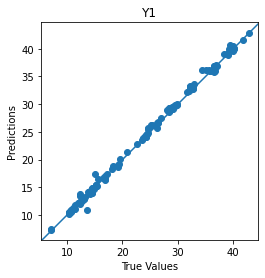

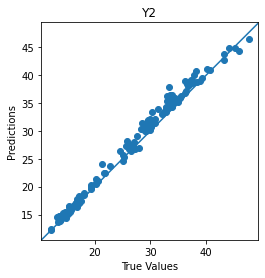

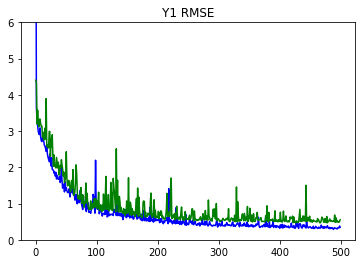

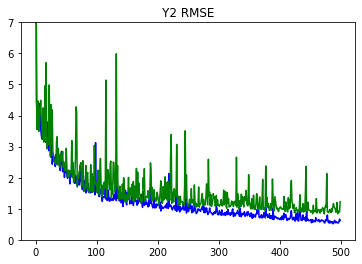

In [9]:
# Plot the loss and mse
Y_pred = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0], title='Y1')
plot_diff(test_Y[1], Y_pred[1], title='Y2')
plot_metrics(metric_name='y1_output_root_mean_squared_error', title='Y1 RMSE', ylim=6)
plot_metrics(metric_name='y2_output_root_mean_squared_error', title='Y2 RMSE', ylim=7)